# Binary Sentiment Analysis of Hotel Reviews

## Setting up the environment

In [1]:
 # Mount a connection between our Colab instance and Google Drive
 #  (we will store the Python environment here)
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks/nlpEnv', nb_path)
sys.path.insert(0, nb_path)

Mounted at /content/drive


In [2]:
# installing  The 'sacremoses' distribution
# to resolve the error
# DistributionNotFound: The 'sacremoses' distribution was not found
# and is required by the application

!pip install transformers -U 

     |████████████████████████████████| 3.4 MB 10.1 MB/s 
     |████████████████████████████████| 596 kB 54.7 MB/s 
     |████████████████████████████████| 3.3 MB 75.3 MB/s 
     |████████████████████████████████| 61 kB 735 kB/s 
     |████████████████████████████████| 895 kB 59.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
# installing dataset
!pip install datasets

     |████████████████████████████████| 298 kB 8.2 MB/s 
     |████████████████████████████████| 243 kB 67.6 MB/s 
     |████████████████████████████████| 132 kB 69.7 MB/s 
     |████████████████████████████████| 1.1 MB 50.9 MB/s 
     |████████████████████████████████| 160 kB 70.8 MB/s 
     |████████████████████████████████| 192 kB 93.6 MB/s 
     |████████████████████████████████| 271 kB 86.7 MB/s 


In [4]:
!pip install --upgrade pyarrow

     |████████████████████████████████| 25.6 MB 1.4 MB/s 
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 3.0.0
    Uninstalling pyarrow-3.0.0:
      Successfully uninstalled pyarrow-3.0.0


## Importing libraries

In [26]:
# importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import pyarrow as pa
import pyarrow.dataset as ds

import datasets
from datasets import Dataset, load_metric
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          TrainingArguments,
                          Trainer)

import torch



## Loading and preprocessing the data

### Loading and exploring the data

In [3]:
# loading the data
raw_datasets = pd.read_csv("review_dataset.csv", index_col=0)


In [4]:
raw_datasets.head()

,review,rating,sentiment
0,Very warm and welcoming staff!\nThe rooms were...,5,1
1,What a lovely place to stay. Beautiful bungalo...,5,1
2,A fantastic place where it's worth spending so...,5,1
3,We have stayed at Ecolodge Ravoraha for 12 day...,5,1
4,"During our whole trip in Madagascar, this was ...",3,0


In [5]:
raw_datasets.tail()

,review,rating,sentiment
1730,Easy process but very long time find out,1,0
1731,nice～,4,1
1732,Low price with cozy place 😍,5,1
1733,Stayed one night. Very luxury room with a good...,5,1
1734,Such a nice and comfortable place to stay.,5,1


In [6]:
raw_datasets.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,5676.0,3.410500,1.603055,1.0,2.0,4.0,5.0,5.0
sentiment,5676.0,0.577343,0.494025,0.0,0.0,1.0,1.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faa52bcd790>,
      dtype=object)

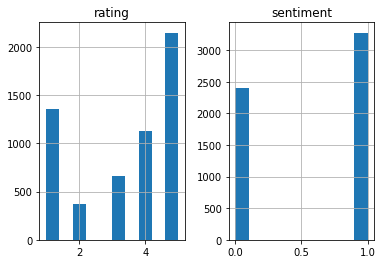

In [7]:
raw_datasets.hist()

In [31]:
# creating a new pd.DataFrame
raw_df =  raw_datasets[["review", "sentiment"]]

# creating train, test and validation data
train_val, test = train_test_split(raw_df,
                                   stratify=raw_datasets["sentiment"],
                                   test_size=0.1)

# separate train_val into train and validation
train_raw, val_raw = train_test_split(train_val,
                                   stratify=train_val["sentiment"],
                                   test_size=0.1)

### Creating Dataset object

In [32]:
# defining a function which creates and returns
# a Dataset object from a pandas dataframe
# input columns must be "review", "sentiment"

def pandas_to_dataset(input_df):
    df = input_df.rename({"review": "text",
                        "sentiment": "label"},
                        axis=1)

    return Dataset(pa.Table.from_pandas(df))


In [34]:
train_ds = pandas_to_dataset(train_raw)
val_ds = pandas_to_dataset(val_raw)
test_ds = pandas_to_dataset(test)

print(f"train_ds:\n{train_ds}\n\nval_ds:\n{val_ds}\n\ntest_ds:\n{test_ds}\n")

train_ds:
Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 4597
})

val_ds:
Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 511
})

test_ds:
Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 568
})



In [35]:
train_ds["text"][:3]

['Really amazing stay! so clean, so hospitable and Ms Nu goes above and beyond to ensure you have a comfortable stay. She also is a travel agent and can help you book things on your trip! …',
 'This is my first time in Hong Kong) the first day when I arrived to Hong Kong i try to find my hostel I spend a lot of money and time to find it, hostel is so difficult to find and when i try to call them number isn’t working ( omg by the …',
 'Cozy spot! We got a double cabin and it was surprisingly comfortable and quiet. Bathrooms are remodeled and nice. Everyone arrives around 10pm, so get ready for bed 9 or earlier or later than 11 to avoid bathroom lines. The only complaint …']

In [36]:
train_ds["label"][:3]

[1, 0, 1]

### Tokenizing

In [15]:
# initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# defining a tokenizer function
# to be used as argument of the .map method 
# of a datasets.dataset_dict.DatasetDict object

def tokenize_function(elements):
    return tokenizer(elements["text"],
                     max_length=512,
                     padding="max_length",
                     truncation=True)


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [37]:
tokenized_train = train_ds.map(tokenize_function,
                               batched=True)

tokenized_val = val_ds.map(tokenize_function,
                               batched=True)

tokenized_test = test_ds.map(tokenize_function,
                               batched=True)


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [38]:
tokenized_train

Dataset({
    features: ['__index_level_0__', 'attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
    num_rows: 4597
})

In [40]:
tokenized_train = tokenized_train.remove_columns(['__index_level_0__'])
tokenized_val = tokenized_val.remove_columns(['__index_level_0__'])

## Creating and Training the Model

In [41]:
# initializing the BERT base pretrained model
model = AutoModelForSequenceClassification.\
            from_pretrained("bert-base-cased", num_labels=2)


loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/bert-base-cased/resolve/

In [42]:
# defining a classification head for the BERT base model
# we will train only this part 

# loading accuracy as metric
metric = load_metric("accuracy")

# defining a function wchi computes metric
def compute_metrics(eval_pred):
    probas, labels = eval_pred
    predictions = np.argmax(probas, axis=-1)

    return metric.compute(predictions=predictions,
                          references=labels)

# instatiate some subsset of the training arguments
training_args = TrainingArguments("test_trainer",
                                   evaluation_strategy="epoch")

# instantiate the Trainer
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=tokenized_train,
                  eval_dataset=tokenized_val,
                  compute_metrics=compute_metrics)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [43]:
# training the classification head
trainer.train()


The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 4597
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1725


Epoch,Training Loss,Validation Loss,Accuracy
1,0.461800,0.404931,0.863014
2,0.362900,0.403956,0.870841
3,0.280500,0.498282,0.861057


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 511
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 511
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-1500/config.json
Model weights saved in test_trainer/checkpoint-1500/pytorch

TrainOutput(global_step=1725, training_loss=0.3513502303413723, metrics={'train_runtime': 839.4675, 'train_samples_per_second': 16.428, 'train_steps_per_second': 2.055, 'total_flos': 3628564564469760.0, 'train_loss': 0.3513502303413723, 'epoch': 3.0})

In [45]:
# looking at the validation score
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 511
  Batch size = 8


{'epoch': 3.0,
 'eval_accuracy': 0.8610567514677103,
 'eval_loss': 0.4982817471027374,
 'eval_runtime': 10.2993,
 'eval_samples_per_second': 49.615,
 'eval_steps_per_second': 6.214}

### Evaluating the model

In [50]:
test_preds = trainer.predict(tokenized_test)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Prediction *****
  Num examples = 568
  Batch size = 8


In [54]:
test_preds

PredictionOutput(predictions=array([[-2.9214237,  2.3802464],
       [ 2.9505901, -2.0324576],
       [-2.9674838,  2.290961 ],
       ...,
       [ 3.1131213, -2.3110783],
       [-2.8309677,  1.6959879],
       [ 2.9970677, -2.198716 ]], dtype=float32), label_ids=array([1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
    

In [56]:
type(test_preds)

transformers.trainer_utils.PredictionOutput

In [57]:
test_preds.metrics

{'test_accuracy': 0.8838028169014085,
 'test_loss': 0.45808860659599304,
 'test_runtime': 11.3283,
 'test_samples_per_second': 50.14,
 'test_steps_per_second': 6.268}